In [1]:
from itertools import product

import matplotlib.pyplot as plt
import numpy as np

from superfv import OutputLoader

base_path = "/scratch/gpfs/jp7427/out/isotropic-decaying-turbulence/"

In [2]:
def isotropic_2d_spectrum(
    vx, vy, rho=None, dx=1.0, dy=1.0, density_weighted=True, nbins=None
):
    """
    Compute isotropic shell-integrated 2D kinetic energy spectrum E(k)

    Parameters
    ----------
    vx, vy : ndarray, shape (nx, ny)
        Velocity components
    rho : ndarray, optional, shape (nx, ny)
        Density field; used for density-weighted KE
    dx, dy : float
        Grid spacing
    density_weighted : bool
        If True and rho is given, use sqrt(rho)*v for KE
    nbins : int, optional
        Number of radial bins in k-space

    Returns
    -------
    k_centers : ndarray
        Radial wavenumber bin centers
    E_k : ndarray
        Shell-integrated kinetic energy per bin
    """

    nx, ny = vx.shape
    assert vy.shape == (nx, ny)
    if rho is not None and density_weighted:
        wx = np.sqrt(np.maximum(rho, 0)) * vx
        wy = np.sqrt(np.maximum(rho, 0)) * vy
    else:
        wx, wy = vx, vy

    # 2D FFT, normalized to match Parseval
    wx_hat = np.fft.fft2(wx) / (nx * ny)
    wy_hat = np.fft.fft2(wy) / (nx * ny)

    # Kinetic energy per mode
    ke_hat_sq = 0.5 * (np.abs(wx_hat) ** 2 + np.abs(wy_hat) ** 2)

    # Wavenumber grids
    kx = 2 * np.pi * np.fft.fftfreq(nx, dx)
    ky = 2 * np.pi * np.fft.fftfreq(ny, dy)
    kx, ky = np.meshgrid(kx, ky, indexing="ij")
    k = np.sqrt(kx**2 + ky**2)

    # Flatten for binning
    k_flat = k.ravel()
    ke_flat = ke_hat_sq.ravel()

    if nbins is None:
        nbins = min(nx, ny) // 2

    kmax = max(kx.max(), ky.max())  # k_flat.max()
    nbins = nx // 2
    bins = np.linspace(0.0, kmax, nbins + 1)

    E_k, _ = np.histogram(k_flat, bins=bins, weights=ke_flat)

    # bin_idx = np.digitize(k_flat, bins) - 1

    # # Shell-integrated E(k)
    # E_k = np.zeros(nbins)
    # for i in range(ke_flat.size):
    #     b = bin_idx[i]
    #     if 0 <= b < nbins:
    #         E_k[b] += ke_flat[i]  # sum energy in shell

    # Radial bin centers
    k_centers = 0.5 * (bins[:-1] + bins[1:])
    dk = bins[1:] - bins[:-1]

    return k_centers, E_k / dk

In [3]:
def plot_spectra(sim, ax, style=None, n=-1, M_max=1):
    idx = sim.variable_index_map
    mesh = sim.mesh
    w = sim.snapshots[n]["w"]

    k_centers, E_k = isotropic_2d_spectrum(
        w[idx("vx")][:, :, 0],
        w[idx("vy")][:, :, 0],
        # rho=w[idx("rho")][:, :, 0],
        dx=mesh.hx,
        dy=mesh.hy,
    )

    ax.plot(
        k_centers[1:], E_k[1:] / M_max**2, **(style if style is not None else dict())
    )

In [4]:
sim_cache = {}

Successfully read simulation output from "/scratch/gpfs/jp7427/out/isotropic-decaying-turbulence/32x32/ZS3/M_max_0.01/seed_01"
Successfully read simulation output from "/scratch/gpfs/jp7427/out/isotropic-decaying-turbulence/32x32/ZS7/M_max_0.01/seed_01"
Successfully read simulation output from "/scratch/gpfs/jp7427/out/isotropic-decaying-turbulence/64x64/ZS3/M_max_0.01/seed_01"
Successfully read simulation output from "/scratch/gpfs/jp7427/out/isotropic-decaying-turbulence/64x64/ZS7/M_max_0.01/seed_01"
Successfully read simulation output from "/scratch/gpfs/jp7427/out/isotropic-decaying-turbulence/128x128/cupy/ZS3/M_max_0.01/seed_01"
Successfully read simulation output from "/scratch/gpfs/jp7427/out/isotropic-decaying-turbulence/128x128/cupy/ZS7/M_max_0.01/seed_01"
Successfully read simulation output from "/scratch/gpfs/jp7427/out/isotropic-decaying-turbulence/32x32/ZS3/M_max_0.1/seed_01"
Successfully read simulation output from "/scratch/gpfs/jp7427/out/isotropic-decaying-turbulence/3

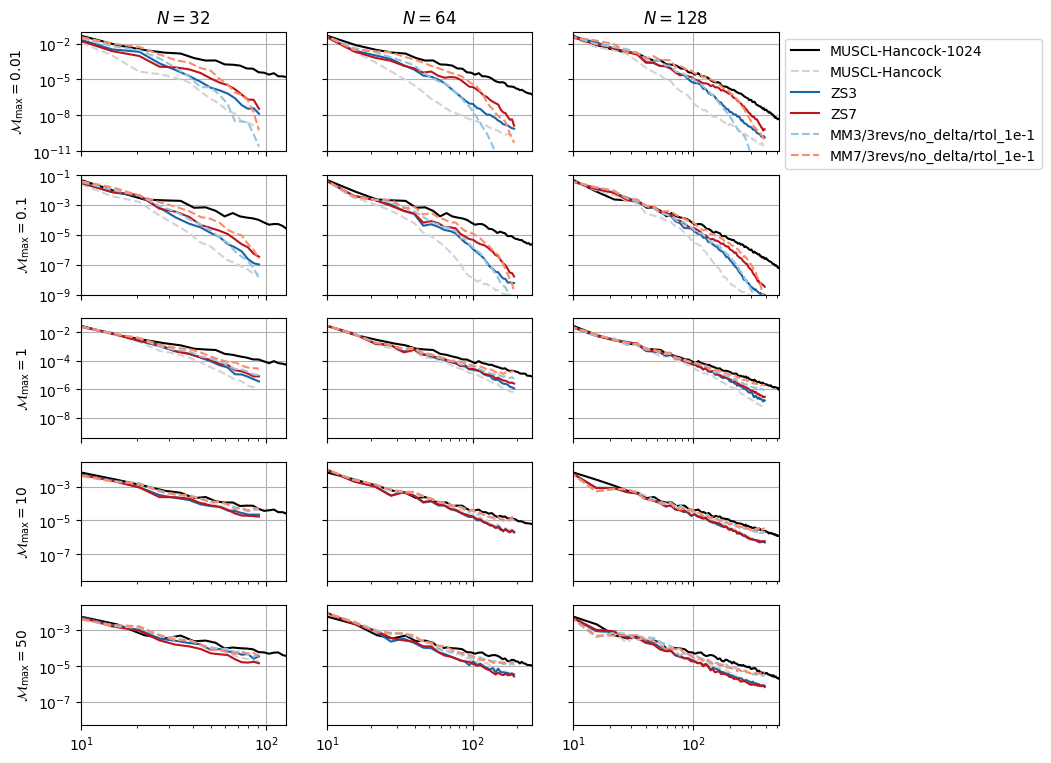

In [7]:
M_max_values = [0.01, 0.1, 1, 10, 50]
N_values = [32, 64, 128]
seed = 1

fig, axs = plt.subplots(
    len(M_max_values),
    len(N_values),
    sharex="col",
    sharey="row",
    figsize=(1.5 * (len(M_max_values) + 1), 3 * len(N_values)),
)
for i, j in product(range(len(M_max_values)), range(len(N_values))):
    axs[i, j].set_xscale("log")
    axs[i, j].set_yscale("log")
    axs[i, j].grid()

for i, M_max in enumerate(M_max_values):
    axs[i, 0].set_ylabel(r"$\mathcal{M}_{\max}" + f"={M_max}$")
axs[0, 0].set_ylim(1e-11, 1e-1)
axs[1, 0].set_ylim(1e-9, 1e-1)
# axs[2, 0].set_ylim(1e-8, 1e-1)
# axs[3, 0].set_ylim(1e-7, 1e-1)
# axs[4, 0].set_ylim(1e-7, 1e-1)
# axs[5, 0].set_ylim(1e-7, 1e-1)

for j, N in enumerate(N_values):
    axs[0, j].set_title(rf"${N=}$")
    axs[0, j].set_xlim(1e1, 4 * N)


cmap1 = plt.get_cmap("Blues")
cmap2 = plt.get_cmap("Reds")
styles = {
    "MUSCL-Hancock-1024": dict(color="black"),
    "MUSCL-Hancock": dict(color="lightgrey", linestyle="--"),
    "ZS3": dict(color=cmap1(0.8)),
    "ZS7": dict(color=cmap2(0.8)),
    "MM3/3revs/no_delta/rtol_1e-1": dict(color=cmap1(0.4), linestyle="--"),
    "MM7/3revs/no_delta/rtol_1e-1": dict(color=cmap2(0.4), linestyle="--"),
    # "MM3/3revs/no_delta/rtol_1e-2": dict(color=cmap1(0.5), linestyle="--"),
    # "MM7/3revs/no_delta/rtol_1e-2": dict(color=cmap2(0.5), linestyle="--"),
    # "MM3/3revs/no_delta/rtol_1e-3": dict(color=cmap1(0.7), linestyle="--"),
    # "MM7/3revs/no_delta/rtol_1e-3": dict(color=cmap2(0.7), linestyle="--"),
}

for (i, M_max), (j, N), (scheme, style) in product(
    enumerate(M_max_values), enumerate(N_values), styles.items()
):
    key = (
        (scheme, M_max, 1024, seed)
        if scheme == "MUSCL-Hancock-1024"
        else (scheme, M_max, N, seed)
    )

    if key in sim_cache:
        sim = sim_cache[key]
    else:
        if scheme == "MUSCL-Hancock-1024":
            sim_path = (
                base_path
                + f"1024x1024/cupy/MUSCL-Hancock/M_max_{M_max}/seed_{seed:02d}"
            )
        else:
            sim_path = (
                base_path
                + f"{N}x{N}/"
                + ("cupy/" if N >= 128 else "")
                + scheme
                + f"/M_max_{M_max}/seed_{seed:02d}"
            )

        try:
            sim = OutputLoader(sim_path)
            sim_cache[key] = sim
        except FileNotFoundError:
            print(f"Could not find\n{sim_path}\nMoving on.")
            continue

    plot_spectra(sim, axs[i, j], style=style | dict(label=scheme), M_max=M_max)

axs[0, -1].legend(loc="upper left", bbox_to_anchor=(1, 1))

In [8]:
fig.savefig("spectra.pdf", bbox_inches="tight")

In [ ]:
sim0 = OutputLoader(f"{base_path}1024x1024/cupy/MUSCL-Hancock/M_max_0.01/seed_01")
sim1 = OutputLoader(f"{base_path}128x128/cupy/MUSCL-Hancock/M_max_0.01/seed_01")
sim2 = OutputLoader(
    f"{base_path}128x128/cupy/MM3/3revs/no_delta/rtol_1e-1/M_max_0.01/seed_01"
)
sim3 = OutputLoader(
    f"{base_path}128x128/cupy/MM7/3revs/no_delta/rtol_1e-1/M_max_0.01/seed_01"
)

fig, ax = plt.subplots(figsize=(5, 4))
ax.set_xlabel(r"$k$")
ax.set_ylabel(r"$E(k)$")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim(1e1, 3e2)
ax.set_ylim(1e-12, 1e-1)

plot_spectra(
    sim0,
    ax,
    style=dict(color="k", linestyle="--", label="ref", linewidth=2),
    M_max=0.01,
)
plot_spectra(sim1, ax, style=dict(label=r"$p=1$", linewidth=2), M_max=0.01)
plot_spectra(sim2, ax, style=dict(label=r"$p=3$", linewidth=2), M_max=0.01)
plot_spectra(sim3, ax, style=dict(label=r"$p=7$", linewidth=2), M_max=0.01)

ax.legend()

In [ ]:
fig.savefig("talk_plot.png", dpi=300, bbox_inches="tight")